# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
sns.set(context='paper')

#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [2]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu
0,51624,male,34,White,High School,Married,25000-34999,30000.0,1.36,6.0,...,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0
1,51630,female,49,White,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,...,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0
2,51638,male,9,White,NaN,NaN,75000-99999,87500.0,1.84,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,51646,male,8,White,NaN,NaN,55000-64999,60000.0,2.33,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,51647,female,45,White,College Grad,Married,75000-99999,87500.0,5.00,6.0,...,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0


In [3]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
df_test.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51625,male,4,Other,NaN,NaN,20000-24999,22500.0,1.07,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51678,male,60,White,High School,Married,15000-19999,17500.0,1.03,5.0,...,NaN,NaN,No,Yes,20.0,1.0,NaN,No,NaN,NaN
2,51694,male,38,White,Some College,Married,20000-24999,22500.0,1.15,6.0,...,No,NaN,No,Yes,23.0,1.0,1.0,No,Heterosexual,NaN
3,51695,male,8,White,NaN,NaN,65000-74999,70000.0,3.55,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51711,female,59,Other,8th Grade,Widowed,20000-24999,22500.0,1.37,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

In [6]:
def expected_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [5]:
### fancy models that solve the problem
num = df.select_dtypes(include = 'number')

In [7]:
num = num.set_index('ID')
num.fillna(0, inplace=True)

In [8]:
from sklearn import tree
from sklearn.model_selection import train_test_split


train, test = train_test_split(num, test_size=0.2)

X_train = train.drop('flu', axis=1)
X_test = test.drop('flu', axis=1)
y_train = train['flu']
y_test = test['flu']

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

array([0.70556354, 0.72123547, 0.67069348, 0.59775369, 0.70846937,
       0.61499282, 0.68736505, 0.66158477, 0.71674409, 0.67031996])

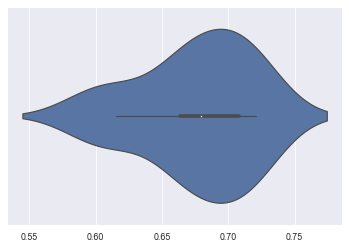

In [25]:
from sklearn.model_selection import cross_val_score

rf_s = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
sns.violinplot(rf_s)
rf_s

In [103]:
def random_forest(it, X_train, y_train):
    df = pd.DataFrame()
    models = {}
    for i in it:
        rf = RandomForestClassifier(max_depth=4,n_estimators=i, class_weight='balanced')
        rf.fit(X_train, y_train)
        models[i] = rf
        df[i] = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
    return df,models

In [106]:
rf, models = random_forest(range(22,202,10), X_train, y_train)

,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162,172,182,192
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.685033,0.686922,0.678491,0.687443,0.698967,0.698550,0.700850,0.692709,0.698608,0.703303,0.695779,0.701757,0.696133,0.703123,0.699217,0.697272,0.698444,0.697321
std,0.051191,0.061457,0.055551,0.054005,0.057783,0.060905,0.057420,0.056703,0.059382,0.061548,0.063586,0.061002,0.063450,0.062729,0.058658,0.063874,0.062398,0.062970
min,0.607908,0.601247,0.587763,0.599582,0.607353,0.602749,0.591583,0.592464,0.593052,0.607092,0.598472,0.589591,0.610357,0.596970,0.599386,0.595403,0.579927,0.596252
25%,0.650334,0.642371,0.644252,0.653599,0.664171,0.671722,0.688790,0.664456,0.664938,0.676043,0.644932,0.681919,0.654701,0.664229,0.664634,0.658305,0.664954,0.659584
50%,0.682819,0.685366,0.688031,0.697564,0.703369,0.702774,0.714299,0.711669,0.701987,0.711708,0.704924,0.711306,0.698690,0.710400,0.706494,0.704759,0.712030,0.700421
75%,0.730287,0.739109,0.721300,0.726085,0.735723,0.745761,0.729052,0.736393,0.742392,0.752095,0.745503,0.741967,0.743291,0.747488,0.739055,0.749834,0.745664,0.746621
max,0.749184,0.765803,0.744221,0.753298,0.793653,0.777001,0.786764,0.751390,0.776675,0.774389,0.770080,0.789474,0.790584,0.789865,0.780136,0.781801,0.761068,0.772169


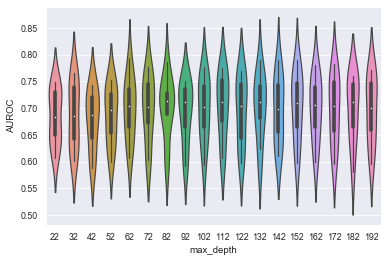

In [107]:
ax = sns.violinplot(data = rf)
ax.set(xlabel='max_depth', ylabel='AUROC')
rf.describe()

In [108]:
score(models[82], X_test, y_test)

overall accuracy       0.794286
accuracy on class 0    0.816887
accuracy on class 1    0.462687
dtype: float64

In [ ]:
def random_forest_class(it, X_train, y_train):
    df = pd.DataFrame()
    models = {}
    for i in it:
        rf = RandomForestClassifier(max_depth=42, )
        rf.fit(X_train, y_train)
        models[i] = dt
        df[i] = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
    return df,models

In [109]:
num_test = df_test.select_dtypes(include='number')
num_test = num_test.set_index('ID')
num_test.fillna(0, inplace=True) 

In [110]:
a = np.array(models[62].predict(num_test))
result = pd.DataFrame(np.array([num_test.index, a]).T, columns=['ID', 'Prediction'])

In [111]:
result.to_csv('result1.csv', index=False)

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pca_ready = pd.DataFrame(StandardScaler().fit_transform(num.drop('flu', axis=1)))
pca.fit_transform(pca_ready)
pca_ready

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-0.046815,-0.556815,-0.601527,-0.046121,0.635343,-0.266022,-0.108284,0.294660,0.771816,0.292767,...,-0.236076,-0.190199,-0.483815,-0.475602,1.509374,1.660407,-0.356173,0.778638,0.006050,0.207753
1,0.604503,-0.270704,-0.287459,-0.486030,0.612206,-0.266022,-0.108284,0.389882,0.590787,0.834277,...,-0.236076,-0.190199,0.229634,-0.236300,3.841818,1.791241,-0.356173,0.340314,0.050283,0.207753
2,-1.132344,1.088323,-0.327431,-0.046121,-1.268513,-0.266022,-0.108284,-0.518583,-0.917787,0.698899,...,7.315483,-0.190199,-0.483815,-0.475602,-0.589824,-0.563761,-0.356173,-0.974655,-0.170883,-0.340472
3,-1.175765,0.301518,-0.047626,0.393788,-1.090026,-0.266022,-0.108284,-0.582922,-0.498678,0.360456,...,1.274236,6.261005,-0.483815,-0.475602,-0.589824,-0.563761,-0.356173,-0.974655,-0.170883,-0.340472
4,0.430818,1.088323,1.477030,-0.046121,0.248623,-0.266022,-0.108284,0.346132,0.225438,0.022012,...,-0.236076,-0.190199,0.586359,0.146582,-0.589824,1.137074,-0.356173,0.449895,0.271449,-0.340472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5241,1.299241,0.301518,0.888867,-0.046121,0.070136,-0.266022,-0.108284,0.037305,0.462421,0.225078,...,-0.236076,-0.190199,-0.483815,-0.475602,-0.589824,-0.563761,-0.356173,0.997799,-0.104533,-0.340472
5242,-0.307342,-1.200565,-1.115455,-1.365847,0.797303,-0.266022,-0.108284,0.618929,0.462421,0.225078,...,-0.236076,-0.190199,-0.483815,-0.475602,1.509374,-0.563761,-0.356173,-0.974655,-0.170883,-0.340472
5243,-1.523134,1.088323,0.546248,1.713515,-2.032039,2.875127,9.453038,-3.943987,-2.763185,-2.076337,...,-0.236076,-0.190199,-0.483815,-0.475602,-0.589824,-0.563761,-0.356173,-0.974655,-0.170883,-0.340472
5244,-0.350763,1.088323,0.477724,1.713515,0.942737,-0.266022,-0.108284,0.580325,0.670879,0.428145,...,-0.236076,-0.190199,1.299808,-0.427741,-0.589824,2.314574,-0.356173,1.326541,-0.148767,0.207753


In [ ]:
print(sum(pca.explained_variance_ratio_))

In [ ]:
def decision_tree(n, X_train, y_train):
    df = pd.DataFrame()
    models = {}
    for i in range(1,n+1):
        dt = tree.DecisionTreeClassifier(max_depth=i)
        dt.fit(X_train, y_train)
        models[i] = dt
        df[i] = cross_val_score(rf, num.drop('flu', axis=1), num['flu'], scoring='roc_auc', cv=10)
    return df,models

In [ ]:
dt, models = decision_tree(20, X_train, y_train)

In [ ]:
ax = sns.boxplot(data = dt)
ax.set(xlabel='max_depth', ylabel='AUROC')
dt.describe()

In [ ]:
score(models[41], X_test, y_test)

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [ ]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [ ]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [ ]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set